In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

In [2]:
random.seed(50)

#### Get thermal gens Boolean index

In [3]:
# Time steps
nt = 12

# All buses
num_buses = 118
buses = np.arange(1, num_buses+1)

# Read thermal buses
file_path = '../../data/IEEE_Case118/zones/thermal_bus.csv'
thermal_buses = pd.read_csv(file_path, header=None, index_col=None)

# Get thermal buses Boolean index
thermal_bidx = np.isin(buses, thermal_buses)

#### Plot UC ground true and prediction

In [4]:
# The number of demonstration plots
num_demos = 100

for i in range(num_demos):
    # Read UC true
    file_path = f'./model_evaluation/PG_true2/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx]

    # Read UC prediction
    file_path = f'./model_evaluation/PG_pred2/pred_{i+1}.csv'
    PG_pred= pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]

    # Calculate relative error
    rela_err = np.zeros(PG_true.shape)
    indices = np.where(PG_true!=0)
    rela_err[indices] = np.abs((PG_true[indices]-PG_pred[indices])/PG_true[indices]) * 100
    indices = np.where((PG_true==0) & (PG_pred==0))
    rela_err[indices] = 0.
    indices = np.where((PG_true==0) & (PG_pred!=0))
    rela_err[indices] = np.NaN
    
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Ground truth (MW)')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('Prediction (MW)')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title('Relative error (%)')

    sns.heatmap(PG_true, 
                ax=ax1,  
                vmin=0,
                xticklabels=[], 
                yticklabels=[],
                linewidth=0.01)
    sns.heatmap(PG_pred, 
                ax=ax2, 
                vmin=0,
                xticklabels=[], 
                yticklabels=[],
                linewidth=0.01)
    sns.heatmap(rela_err,
                ax=ax3,
                vmin=0,
                xticklabels=[],
                yticklabels=[],
                linewidth=0.01)
    plt.tight_layout()
    fig.savefig(f'./model_evaluation/PG_plotting2/fig{i+1}.pdf')
    plt.close('all')

#### Calculate mean relative error (cases where *PG_true==0 & PG_pred!=0* are not considered)

In [5]:
# Overall number of UC
num_data = 2000

# Record relative error
rela_err = np.zeros((num_data, thermal_bidx.sum(), nt))

# Read ground truth
for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/PG_true2/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx]

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred2/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx]

    # Calculate relative error
    indices = np.where(PG_true!=0) 
    rela_err[i][indices] = np.abs((PG_true[indices]-PG_pred[indices])/PG_true[indices]) * 100

    indices = np.where((PG_true==0) & (PG_pred==0))
    rela_err[i][indices] = 0.

    indices = np.where((PG_true==0) & (PG_pred!=0))
    rela_err[i][indices] = np.NaN

In [6]:
# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

In [8]:
# Read gen buses
file_path = '../../data/IEEE_Case118/zones/gen_bus.csv'
gen_buses = pd.read_csv(file_path, header=None, index_col=None)

# Read thermal buses
file_path = '../../data/IEEE_Case118/zones/thermal_bus.csv'
thermal_buses = pd.read_csv(file_path, header=None, index_col=None)

# Get Booleanindex of thermal buses in gen buses
bidx = np.isin(gen_buses, thermal_buses)

# Get thermal gen features (To be determined)
Pmax = pd.read_csv('../../data/IEEE_Case118/gen_params/Pmax.csv',
                    header=None,
                    index_col=None)

# Get thermal Pmax
thermal_Pmax = Pmax[bidx].to_numpy().flatten().round(2)

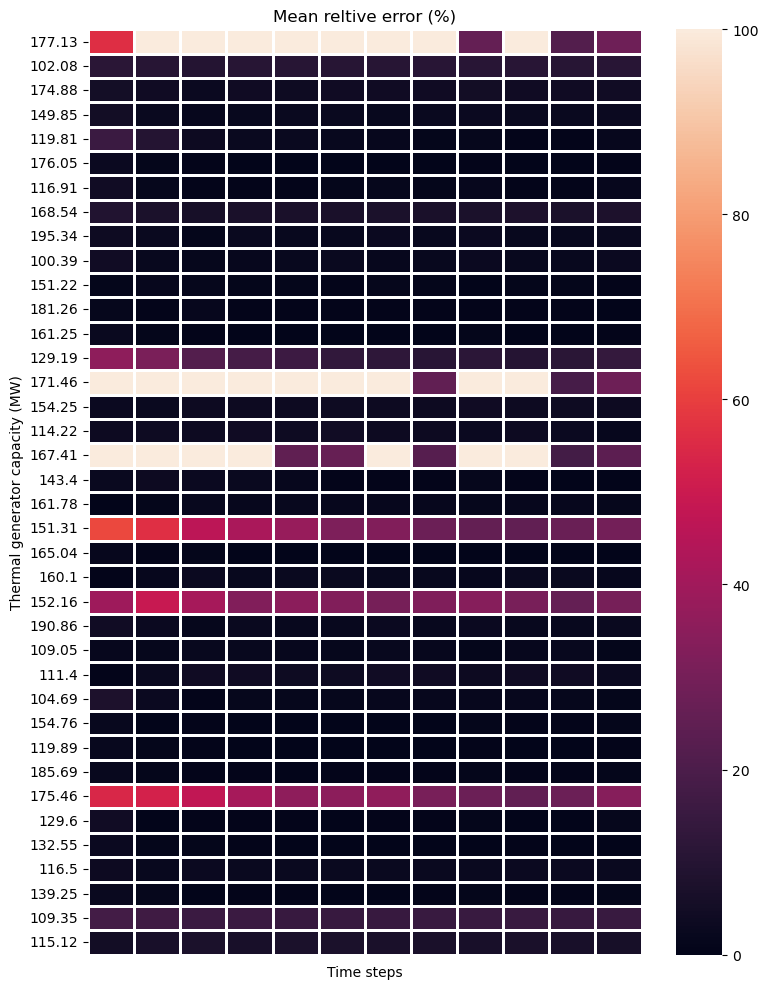

In [9]:
# Plot mean relative error
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111)
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            vmax=100,
            xticklabels=[], 
            yticklabels=thermal_Pmax,
            linewidth=1)
ax.set_title('Mean reltive error (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Thermal generator capacity (MW)')
plt.tight_layout()
plt.show()
plt.close('all')

#### Calculate zonal aggregated PG

In [10]:
# Buses in each zone
file_path = '../../data/IEEE_Case118/zones/zone1_bus.csv'
zone1_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone2_bus.csv'
zone2_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone3_bus.csv'
zone3_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Thermal bidx in each zone
thermal_bidx_zone1 = np.isin(thermal_buses, zone1_buses).flatten()
thermal_bidx_zone2 = np.isin(thermal_buses, zone2_buses).flatten()
thermal_bidx_zone3 = np.isin(thermal_buses, zone3_buses).flatten()

In [11]:
# Overall number of UC
num_data = 2000

# Number of zones
num_zones = 3

# PG sum
PG_sum_true = np.zeros((num_data, num_zones+1, nt))
PG_sum_pred = np.zeros((num_data, num_zones+1, nt))

# Read ground truth
for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/PG_true2/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    temp0 = PG_true[thermal_bidx][thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_true[thermal_bidx][thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_true[thermal_bidx][thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_true[thermal_bidx].sum(axis=0)
    PG_sum_true[i, 0] = temp0.copy()
    PG_sum_true[i, 1] = temp1.copy()
    PG_sum_true[i, 2] = temp2.copy()
    PG_sum_true[i, 3] = temp3.copy()

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred2/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    temp0 = PG_pred[thermal_bidx][thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_pred[thermal_bidx][thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_pred[thermal_bidx][thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_pred[thermal_bidx].sum(axis=0)
    PG_sum_pred[i, 0] = temp0.copy()
    PG_sum_pred[i, 1] = temp1.copy()
    PG_sum_pred[i, 2] = temp2.copy()
    PG_sum_pred[i, 3] = temp3.copy()

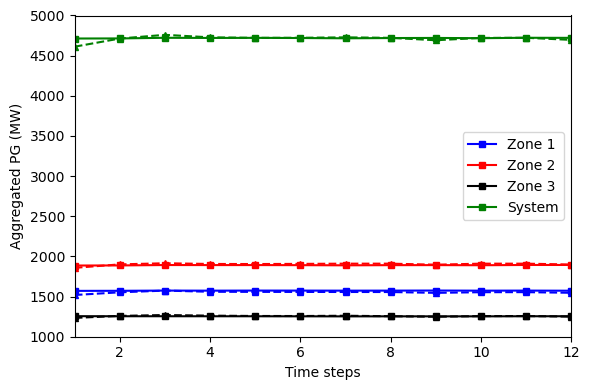

In [12]:
# Plot mean zonal aggregated PG
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[0], linestyle='dashed', color='blue', marker='^', markersize=5)

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[1], linestyle='dashed', color='red', marker='^', markersize=5)

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[2], linestyle='dashed', color='black', marker='^', markersize=5)

# System aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[3], color='green', marker='s', markersize=5, label='System')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[3], linestyle='dashed', color='green', marker='^', markersize=5)

ax.set_xlim((1, 12))
ax.set_ylim((1e3, 5e3))
ax.set_xlabel('Time steps')
ax.set_ylabel('Aggregated PG (MW)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
plt.close('all')

In [13]:
rela_err = np.abs((PG_sum_true-PG_sum_pred)/PG_sum_true) * 100

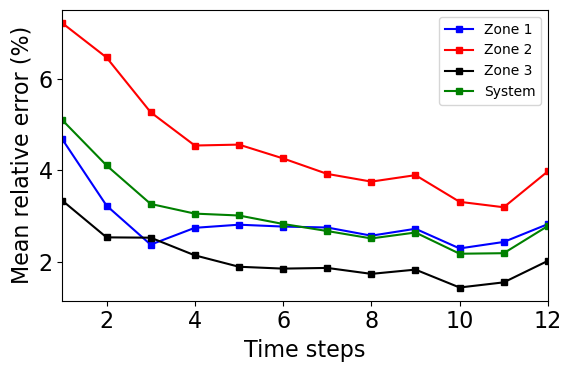

In [15]:
plt.rcParams['font.size'] = 16
# Plot mean zonal aggregated PG relative error
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[0], color='blue', marker='s', markersize=5, label='Zone 1')

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[1], color='red', marker='s', markersize=5, label='Zone 2')

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[2], color='black', marker='s', markersize=5, label='Zone 3')

# System aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[3], color='green', marker='s', markersize=5, label='System')

ax.set_xlim((1, 12))
ax.set_xlabel('Time steps')
ax.set_ylabel('Mean relative error (%)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
plt.close('all')